In [1]:
from tokenizers import Tokenizer
from fourm.vq.vqvae import VQVAE, DiVAE
import os
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import cv2
from IPython.display import display, clear_output
import time
from skimage.metrics import structural_similarity as ssim

import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from fourm.data.modality_transforms import RGBTransform
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD, IMAGENET_DEFAULT_STD, IMAGENET_DEFAULT_MEAN
# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

/home/skalli/.local/lib/python3.10/site-packages/fourm/vq/quantizers/quantize_lucid.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/skalli/.local/lib/python3.10/site-packages/fourm/vq/quantizers/quantize_lucid.py:388: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


xFormers not available
xFormers not available


In [2]:
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer
snapshot_download(
    repo_id='nvidia/Cosmos-0.1-Tokenizer-DI16x16', 
    local_dir='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16'
)
image_tokenizer = ImageTokenizer(
    checkpoint_enc='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/encoder.jit',
    checkpoint_dec='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/decoder.jit',
).to(device)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([1, 3, 640, 640])


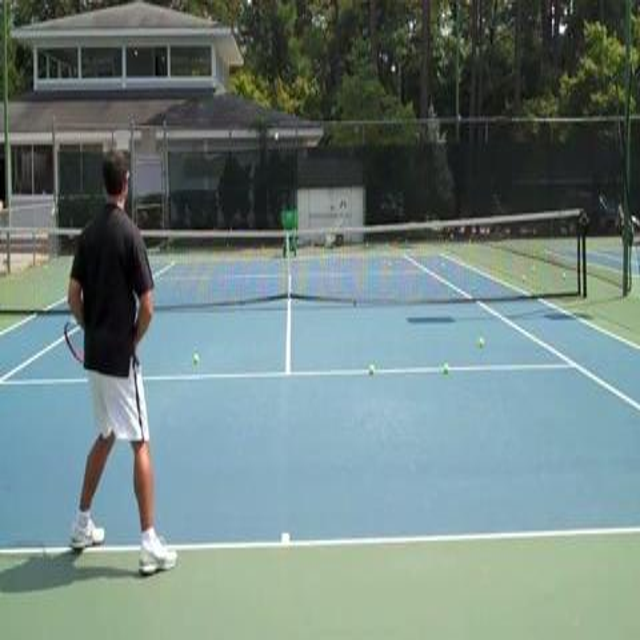

In [3]:
img = Image.open('penn_action_raw/Penn_Action/frames/2000/000001.jpg').resize((640,640))
img_tensor = TF.to_tensor(img).to(device).unsqueeze(0) * 2 - 1
print(img_tensor.shape)
img

In [4]:
tokens, _ = image_tokenizer.encode(img_tensor)
print(tokens.shape)
print(tokens)

torch.Size([1, 40, 40])
tensor([[[45274, 40862, 60925,  ..., 43518, 14294, 55462],
         [13215, 48342, 22151,  ..., 47253, 40437, 26964],
         [46962, 14612, 47827,  ..., 56203, 26887, 33077],
         ...,
         [28421, 43789, 16642,  ..., 18315, 13764, 18691],
         [ 7108, 29570, 13764,  ...,  8577, 13766, 16194],
         [ 7044, 14726, 31435,  ..., 17285,  4291, 19780]]], device='cuda:0',
       dtype=torch.int32)


In [5]:
reconst = image_tokenizer.decode(tokens).float().clamp(-1,1)
reconst.shape

torch.Size([1, 3, 640, 640])

torch.Size([1, 40, 40])
tensor([[[35738, 15244, 53523,  ..., 48525, 14804,  5868],
         [20431, 44973, 12270,  ...,  1495, 15760, 47023],
         [24877,  2534, 49068,  ..., 32146,   813, 49430],
         ...,
         [ 2453,   859, 32018,  ..., 31190, 32198, 40335],
         [15266, 13252, 20315,  ...,  3509,  1303, 27083],
         [17820,  2500, 16096,  ..., 13524, 47485,  4487]]], device='cuda:0',
       dtype=torch.int32)


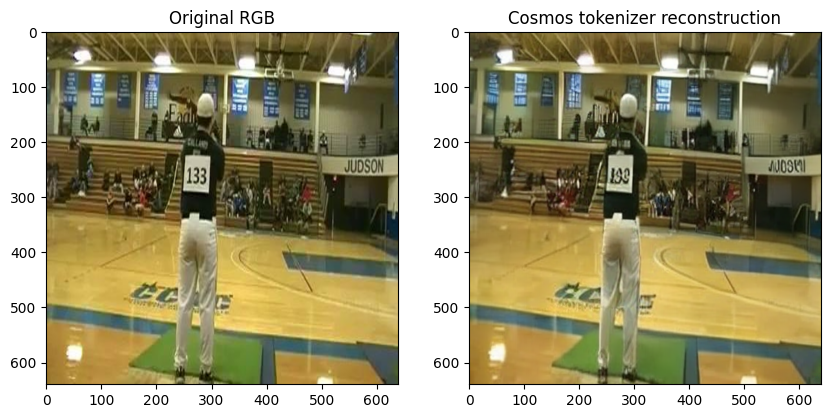

In [7]:
img = Image.open('penn_action_raw/Penn_Action/frames/0088/000001.jpg').resize((640,640))
img_tensor = TF.to_tensor(img).to(device).unsqueeze(0) * 2 - 1
tokens, _ = image_tokenizer.encode(img_tensor)
print(tokens.shape)
print(tokens)
reconst = image_tokenizer.decode(tokens).float().clamp(-1,1)
reconst.shape
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].imshow(img)
ax[0].set_title('Original RGB')
ax[1].imshow(reconst[0].cpu().permute(1,2,0) / 2 + 0.5)
ax[1].set_title('Cosmos tokenizer reconstruction')
plt.show()